In [1]:
import time
import h5py
import os, sys
import numpy as np
from astropy.io import fits
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from scipy.io import wavfile
from scipy.optimize import minimize
from scipy.interpolate import interp2d, interp1d
from scipy.interpolate import NearestNDInterpolator

import ccdproc as ccdp
from astropy import units
from astropy.nddata import CCDData
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d
from astropy.table import Table, Column

%load_ext autoreload
%autoreload 2

from niriss import clipping
from niriss import masking
from niriss import background
from niriss.niriss_extraction import (dirty_mask, optimal_extraction_routine,
                                      box_extract)
from niriss.tracing_niriss import mask_method_ears

from matplotlib.colors import ListedColormap
pmap = ListedColormap(np.load('/Users/belugawhale/parula_data.npy'))
colors = np.load('/Users/belugawhale/parula_colors.npy')

COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

import warnings
warnings.filterwarnings("ignore")

## Eureka! reduced

In [2]:
path = '/Users/belugawhale/Documents/niriss_real/wasp96'
files = np.sort([os.path.join(path, i) for i in os.listdir(path) if i.endswith('calints.fits')])
files = files[4:-1]

In [6]:
readnoise = fits.open('/Users/belugawhale/crds_cache/references/jwst/niriss/jwst_niriss_readnoise_0005.fits')
wave_soln = fits.open(os.path.join(path, 'jw02734002001_04101_00001-seg002_nis_x1dints.fits'))
trace = fits.open('/Users/belugawhale/crds_cache/references/jwst/niriss/jwst_niriss_spectrace_0024.fits')

# Defining the trace from the reference file

In [7]:
trace_guesses = np.full((3,2048), np.nan)
for i in range(1,4):
    if i == 1:
        upp = 2048
    elif i == 2:
        upp = 1900
    else:
        upp = 1000
    inds = (trace[i].data['x']>=-10) & (trace[i].data['x']<=upp) & (np.isnan(trace[i].data['x'])==False)
    interp = interp1d(trace[i].data['x'][inds], trace[i].data['y'][inds])
    try:
        trace_guesses[i-1][:upp] = interp(np.arange(0,upp,1))
    except:
        trace_guesses[i-1][:upp-10] = interp(np.arange(0,upp-10,1))
        
guess_table = Table()
guess_table['x'] = np.arange(0,2048,1)
for i in range(3):
    guess_table['order_{}'.format(i+1)] = trace_guesses[i]

In [8]:
hdu = fits.open(files[0])
order_mask_t1 = dirty_mask(hdu[1].data[0], tab=guess_table, boxsize1=30, boxsize2=30,
                   boxsize3=30, return_together=True, booltype=True)
order_mask_t2 = dirty_mask(hdu[1].data[0], tab=guess_table, boxsize1=65, boxsize2=45,
                           boxsize3=40, return_together=True, booltype=True)
order_mask = dirty_mask(hdu[1].data[0], tab=guess_table, boxsize1=30, boxsize2=30,
                        boxsize3=30, return_together=False, booltype=True)
order_mask_t3 = dirty_mask(hdu[1].data[0], tab=guess_table, boxsize1=70, boxsize2=50,
                           boxsize3=40, return_together=True, booltype=True)
hdu.close()

# Loading in all data segments & initializing arrays

In [9]:
hdus = []
counter = []
for i in range(3):
    hdus.append(fits.open(os.path.join(path, files[i])))
    counter.append(len(hdus[i][1].data))
    
frames = np.zeros((np.nansum(counter), 256, 2048))
variance = np.zeros((np.nansum(counter), 256, 2048))
check = np.zeros(3)
times = np.zeros(np.nansum(counter))
dq = np.zeros((np.nansum(counter), 256, 2048))

for i in range(len(counter)):
    if i == 0:
        start, end = 0, counter[0]
    else:
        start, end = np.nansum(counter[:i]), np.nansum(counter[:i+1])

    frames[start:end] = hdus[i][1].data
    variance[start:end] = hdus[i][5].data
    dq[start:end] = masking.data_quality_mask(hdus[i][3].data) # makes DQ mask
    
    times[start:end] = hdus[i][4].data['int_mid_BJD_TDB']
    
dq_masked = np.zeros(frames.shape)    
f277_rmvd = np.zeros(frames.shape)

# Data Quality Mask

In [10]:
for i in tqdm_notebook(range(len(frames))):
    dq_masked[i] = masking.interpolating_image(frames[i], dq[i])

  0%|          | 0/280 [00:00<?, ?it/s]

# Substrip256 Model Background removal


In [11]:
model_bkg = np.load('/Users/belugawhale/Documents/niriss_real/model_background256.npy')

In [41]:
x1,x2,y1,y2 = 190,250,200,500

test_vals = np.linspace(0.4,0.51,1000)
shape = (y2-y1)*(x2-x1)

vals = np.zeros(len(dq_masked))

for j in tqdm_notebook(range(len(dq_masked))):
    rms = np.zeros(len(test_vals))
    for i, v in enumerate(test_vals):
        rms[i] = np.sqrt(np.nansum((dq_masked[j][x1:x2,y1:y2]-(model_bkg[x1:x2,y1:y2]*v))**2)/shape)
    vals[j] = test_vals[np.argmin(rms)]
    #print(test_vals[np.argmin(rms)])

  0%|          | 0/280 [00:00<?, ?it/s]

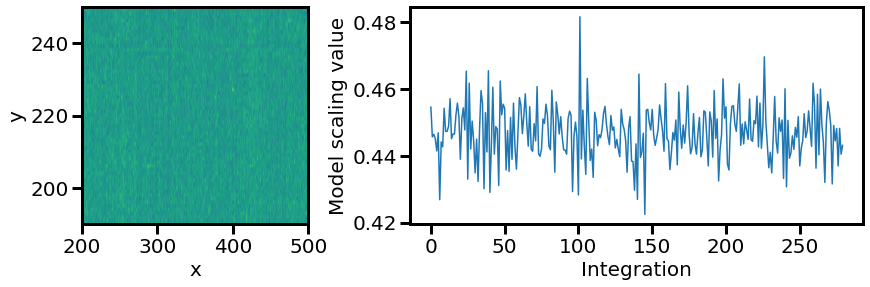

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4), gridspec_kw={'width_ratios':[1,2]})
fig.set_facecolor('w')
ax1.imshow(dq_masked[0], aspect='auto', vmin=-0.1, vmax=4)
ax1.set_ylim(x1,x2)
ax1.set_xlim(y1,y2)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.plot(vals)
ax2.set_xlabel('Integration')
ax2.set_ylabel('Model scaling value')
plt.subplots_adjust(wspace=0.3)
plt.savefig('/Users/belugawhale/Desktop/model_scale.png', dpi=200, rasterize=True,
            bbox_inches='tight')

In [42]:
model_bkg_rmvd = dq_masked - (model_bkg*np.nanmedian(vals))

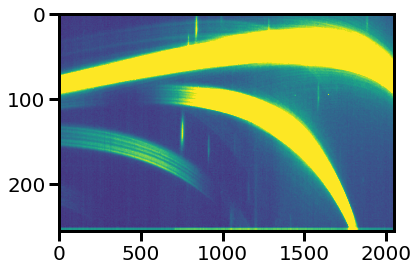

In [44]:
plt.imshow(model_bkg_rmvd[0], aspect='auto', vmin=-1, vmax=5)

# Fitting the F277W filter to minimize residuals

## Loading in best-fit background

In [213]:
f277bkg_order0 = np.load('f277w_order0.npy')
f277bkg = np.load('avg_bkg.npy')

In [214]:
ccd = CCDData(f277bkg_order0, unit=units.electron)
new_ccd = ccdp.cosmicray_lacosmic(ccd, 
                                  readnoise=np.nanmedian(readnoise[1].data), 
                                  sigclip=1.0, verbose=False)
mask = new_ccd.data >= (np.nanmedian(new_ccd.data)+np.nanstd(new_ccd.data)*2)

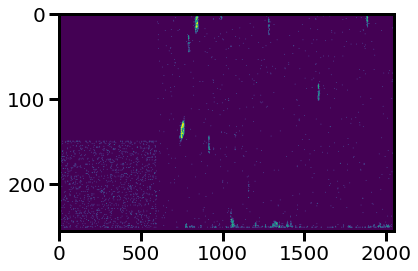

In [215]:
more_outliers = np.zeros(new_ccd.data.shape)
for ind in range(2048):
    x = ( (new_ccd.data[:,ind] >= np.nanmedian(new_ccd.data[:,ind])+np.nanstd(new_ccd.data[:,ind])*3) &
          (new_ccd.data[:,ind] <= np.nanmedian(new_ccd.data[:,ind])+np.nanstd(new_ccd.data[:,ind])*4) )
    more_outliers[:,ind][x] = 1
plt.imshow(more_outliers, aspect='auto', vmin=0, vmax=1)
#plt.xlim(1000,1100)

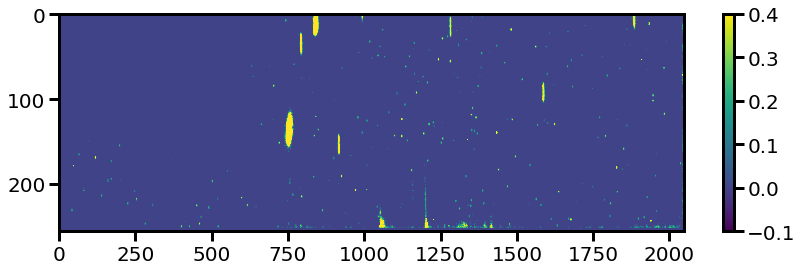

In [225]:
fig = plt.figure(figsize=(14,4))
fig.set_facecolor('w')
plt.imshow(mask*new_ccd.data, vmin=-0.1, vmax=0.4, aspect='auto')
plt.colorbar()
plt.savefig('/Users/belugawhale/Desktop/f277_full.png', dpi=200, 
           rasterize=True, bbox_inches='tight')

In [244]:
y1,y2,x1,x2 = 700,1000,115,170

test_vals = np.linspace(1.5,2.5,1000)
new_bkg   = mask*new_ccd.data

scaling_vals = np.zeros(len(dq_masked))

for j in tqdm_notebook(range(len(dq_masked))):
    rms = np.zeros(len(test_vals))
    for i, v in enumerate(test_vals):
        rms[i] = np.sqrt(np.nansum((model_bkg_rmvd[j][x1:x2,y1:y2]-(new_bkg[x1:x2,y1:y2]*v))**2)/(55*300))
    scaling_vals[j] = test_vals[np.argmin(rms)]

  0%|          | 0/280 [00:00<?, ?it/s]

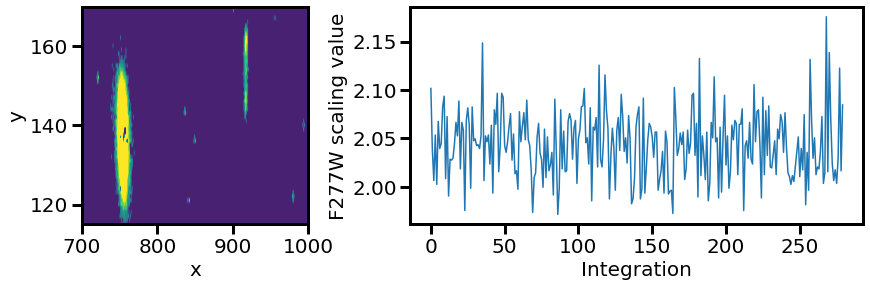

In [248]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4), gridspec_kw={'width_ratios':[1,2]})
fig.set_facecolor('w')
ax1.imshow(new_bkg, aspect='auto', vmin=-0.1, vmax=1)
ax1.set_ylim(x1,x2)
ax1.set_xlim(y1,y2)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.plot(scaling_vals)
ax2.set_xlabel('Integration')
ax2.set_ylabel('F277W scaling value')
plt.subplots_adjust(wspace=0.3)
plt.savefig('/Users/belugawhale/Desktop/f277w_scale.png', dpi=200, rasterize=True,
            bbox_inches='tight')

Text(0.5, 1.0, 'F277W "Model"')

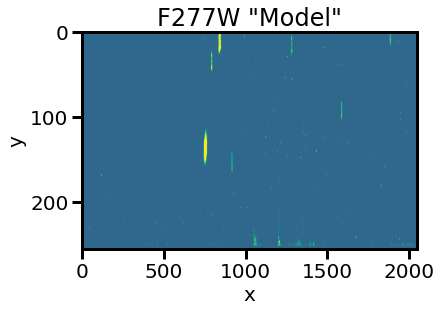

In [249]:
fig = plt.figure()
fig.set_facecolor('w')

plt.imshow(new_bkg, aspect='auto', vmin=-0.5, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('F277W "Model"')
#plt.savefig('/Users/belugawhale/Desktop/f277w_filter.png', dpi=200, rasterize=True,
#            bbox_inches='tight')

In [250]:
f277_rmvd = model_bkg_rmvd - (new_bkg*np.nanmedian(scaling_vals))

# Retracing the trace

In [251]:
med = np.nanmedian(f277_rmvd, axis=0)

In [252]:
%load_ext autoreload
%autoreload 2

from niriss.tracing_niriss import mask_method_ears

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [253]:
tab = mask_method_ears(f277_rmvd[0], readnoise=np.nanmedian(readnoise[1].data), 
                       isplots=4, 
                       degree=4)

(256.0, 0.0)

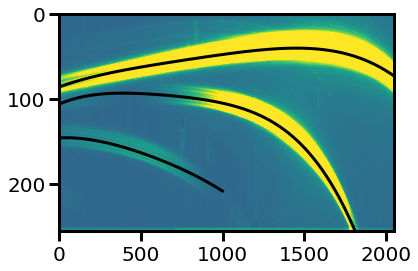

In [254]:
plt.imshow(f277_rmvd[0], aspect='auto', vmin=-5, vmax=10)
for i in range(1,4):
    plt.plot(guess_table['x'], guess_table['order_{}'.format(i)], lw=2, c='r')
    plt.plot(tab['x'], tab['order_{}'.format(i)], lw=3, c='k')
plt.ylim(256,0)

## Remaking the Masks

In [255]:
order_mask_t1 = dirty_mask(f277_rmvd[0], tab=tab, boxsize1=30, boxsize2=30,
                   boxsize3=30, return_together=True, booltype=True)

order_mask_t2 = dirty_mask(f277_rmvd[0], tab=tab, boxsize1=70, boxsize2=50,
                           boxsize3=30, return_together=True, booltype=True)

order_mask = dirty_mask(f277_rmvd[0], tab=tab, boxsize1=30, boxsize2=30,
                        boxsize3=20, return_together=False, booltype=True)

order_mask_t3 = dirty_mask(f277_rmvd[0], tab=tab, boxsize1=74, boxsize2=74,
                           boxsize3=30, return_together=True, booltype=True)

# Decontaminating 2nd order

In [ ]:
bkg_order = dirty_mask(f277_rmvd[0], boxsize1=None, boxsize2=20,
                       pos2=guess_table['order_2'],
                        return_together=False, booltype=True)

In [ ]:
plt.figure(figsize=(14,4))
plt.imshow(med, aspect='auto', vmin=-4, vmax=5)
plt.imshow(bkg_order[1], aspect='auto', cmap='Greys', alpha=0.5)
plt.ylim(150,30)
plt.xlim(0,2048)
xticks = np.linspace(0, 2047, 10, dtype=int)
plt.xticks(xticks, labels=np.round(wave_soln[2].data['WAVELENGTH'][xticks],2));

# Using best-fit parameters from F277W filter to get background for data

## Background routines

In [256]:
def mask_bad(data):
    nan_mask = np.zeros(data.shape, dtype=bool)
    nan_mask[np.isnan(data)] = 1
    nan_mask[data <= -1e1] = 1
    return masking.interpolating_image(data, nan_mask)  

def bkg_processing(data, box=(3,3), filter_size=(3,2), filtersize=10, 
                   mask=None, bkg_estimator='mmmbackground', sigma=1.5):
    global order_mask_t1, order_mask_t2
    
    if mask is None:
        mask = order_mask_t2
    
    b2, b2_err = background.bkg_sub(data[:250], ~mask[:250], 
                                    box=box, filter_size=filter_size, bkg_estimator=bkg_estimator,
                                    sigma=sigma)
    b1, b1_err = background.bkg_sub(data[:250], ~mask[:250], box=(2,5), filter_size=(2,3), 
                                    bkg_estimator=bkg_estimator,
                                    sigma=sigma)
    
    med = np.nanmedian([b1, b2], axis=0)
    
    sf = savgol_filter(med, 73, 4)
    gf = gaussian_filter(med, filtersize)
    return gf, gaussian_filter(b2_err, filtersize)

In [257]:
cr_rmvd = np.zeros(frames.shape)
backgrounds = np.zeros(frames.shape)
subbed = np.zeros(frames.shape)

cr_rmvd_var = np.zeros(frames.shape)
subbed_var = np.zeros(frames.shape)
backgrounds_var = np.zeros(frames.shape)

In [258]:
order_mask_t3 = dirty_mask(f277_rmvd[0],boxsize1=100, boxsize2=80,
                           boxsize3=30, 
                           pos1=tab['order_1']+10,
                           pos2=tab['order_2'],
                           pos3=tab['order_3']-2,
                           return_together=True, booltype=True)
order_mask_t3[:90, 1700:] = False

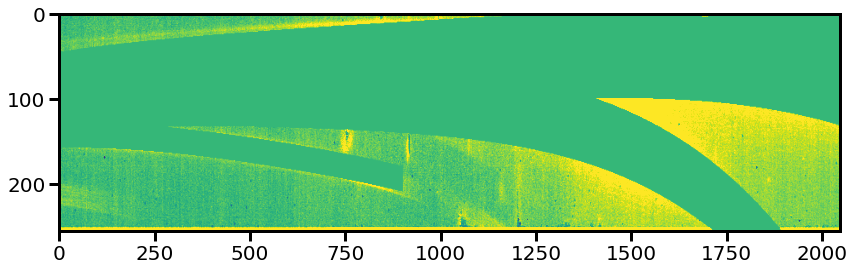

In [259]:
plt.figure(figsize=(14,4))
plt.imshow(f277_rmvd[0]*order_mask_t3, vmin=-2, vmax=1, aspect='auto')

  0%|          | 0/280 [00:00<?, ?it/s]

RMS =  3761862.473765603


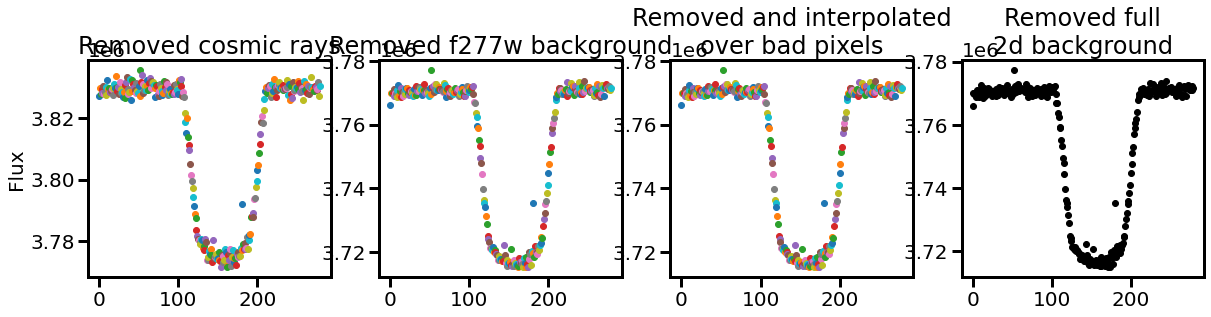

In [264]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20,4), sharex=True)

all_traces = Table()
rms = 0

overall=True
test=False

if test:
    length = 3
else:
    length = len(cr_rmvd)

for i in tqdm_notebook(range(length)):

    ccd = CCDData(f277_rmvd[i], unit=units.electron)
    new_ccd = ccdp.cosmicray_lacosmic(ccd, 
                                      readnoise=np.nanmedian(readnoise[1].data), 
                                      sigclip=4, verbose=False)
    
    var = variance[i] * ~new_ccd.mask # Cosmic ray masked + filled
    
    rmvd = new_ccd.data - np.nanmedian(new_ccd.data, axis=0) # subtracting median along the column

    new_tab = mask_method_ears(rmvd, readnoise=np.nanmedian(readnoise[1].data), isplots=1) # tracing
    for o in range(1,4):
        all_traces.add_column(Column(new_tab['order_{}'.format(o)], 'order_{0}_frame_{1}'.format(o, i)))
    
    # removing additional bad pixels
    cr_rmvd[i] = mask_bad(rmvd)
    cr_rmvd_var[i] = mask_bad(var)
    
    bkg_data, bkg_err = bkg_processing(cr_rmvd[i], box=(3,10), filter_size=(2,5), 
                                       filtersize=10, mask=order_mask_t3, sigma=2)
    #bkg_var  = bkg_processing(cr_rmvd_var[i], box=(2,2), filter_size=(3,2), filtersize=8)
    
    backgrounds[i, :250] = bkg_data
    
    subbed[i] = cr_rmvd[i]# - backgrounds[i] #- np.nanmedian(cr_rmvd[i] - backgrounds[i], axis=0)
    subbed_var[i][:250] = cr_rmvd_var[i][:250] #+ bkg_err 
    
    
    if overall:
        ax1.plot(i, np.nansum(new_ccd.data*order_mask[0]), 'o')
        ax3.plot(i, np.nansum(cr_rmvd[i]*order_mask[0]), 'o')
        ax2.plot(i, np.nansum(rmvd*order_mask[0]), 'o')
        ax4.errorbar(i, np.nansum(subbed[i]*order_mask[0]), 
                     yerr=np.sqrt(np.nansum(subbed_var[i]*order_mask[0])), color='k', marker='o')
    else:
        plt.close()
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(20,10), sharex=True)
        ax1.imshow(rmvd, aspect='auto', vmin=-5, vmax=1)
        ax2.imshow(backgrounds[i], aspect='auto', vmin=-1, vmax=1)
        ax3.imshow(subbed[i], aspect='auto', vmin=-5, vmax=2)
        plt.show()
    
    
    
    rms += np.nansum(subbed[i]*order_mask[0])**2
    
print('RMS = ', np.sqrt(rms/i))
    
ax1.set_title('Removed cosmic rays')
ax2.set_title('Removed f277w background')
ax3.set_title('Removed and interpolated\nover bad pixels')
ax4.set_title('Removed full\n2d background')
ax1.set_ylabel('Flux')
plt.show()

In [265]:
med_bkg = np.nanmedian(backgrounds, axis=0)

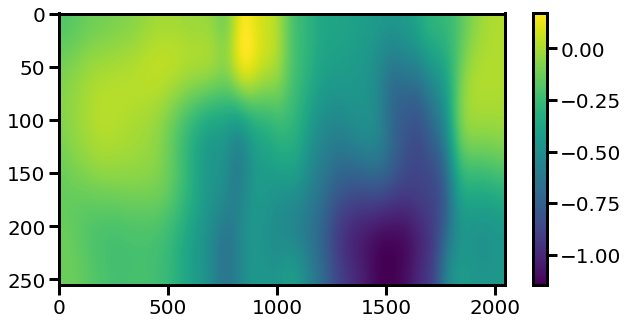

In [273]:
plt.figure(figsize=(10,5))
plt.imshow(gaussian_filter(med_bkg, 30), aspect='auto')
plt.colorbar();

In [261]:
old = h5py.File('ADF_extracted_stellar_spectra_method6.h5')

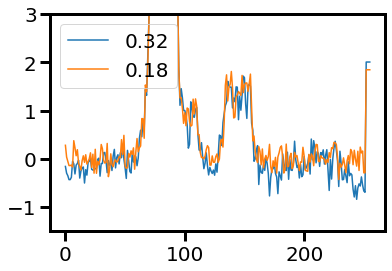

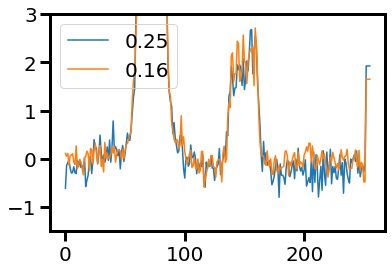

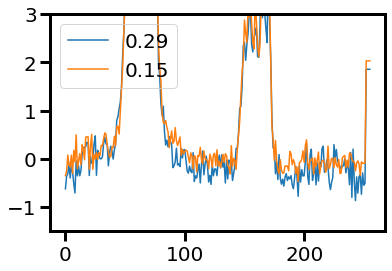

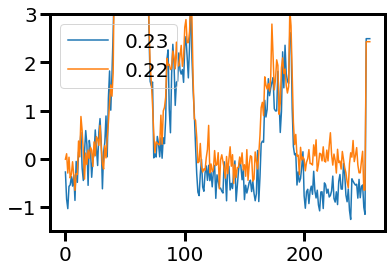

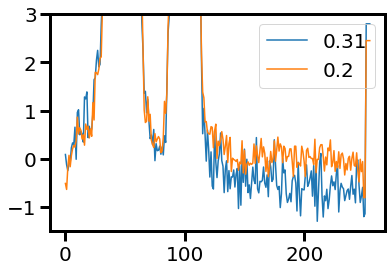

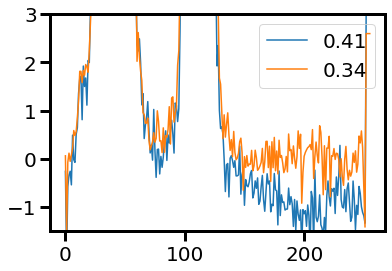

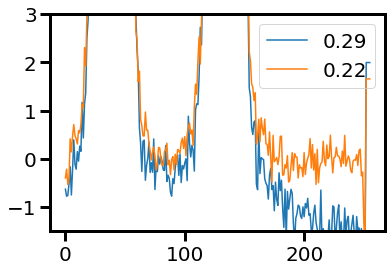

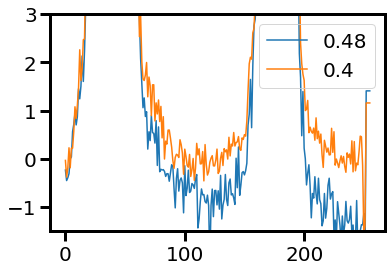

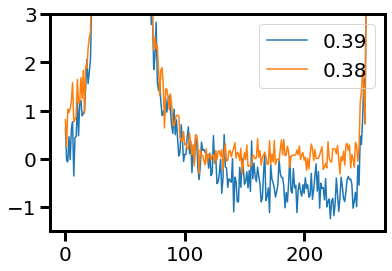

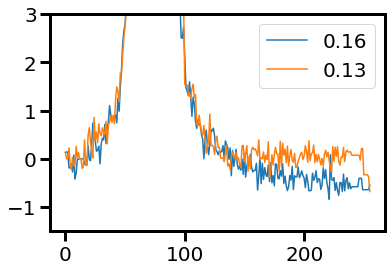

In [294]:
frame = 230
for i in np.linspace(50,2047,10,dtype=int):
    plt.plot(old['cr_rmvd_flux'][frame,:,i], 
             label=np.round(np.nanstd(old['cr_rmvd_flux'][frame,200:250,i]),2))
    plt.plot(subbed[frame,:,i]-med_bkg[:,i], 
             label=np.round(np.nanstd(subbed[frame,200:250,i]-med_bkg[200:250,i]),2))
    plt.ylim(-1.5, 3)
    plt.legend()
    plt.show()

In [295]:
subbed = subbed - med_bkg

## Checking for bad integrations

In [334]:
order_mask = dirty_mask(subbed[0], tab=tab, boxsize1=30, boxsize2=30,
                        boxsize3=30, return_together=False, booltype=True)

In [301]:
y = np.nansum(subbed*order_mask[0], axis=(1,2))
yerr = np.sqrt(np.nansum(subbed_var*order_mask[0], axis=(1,2)))

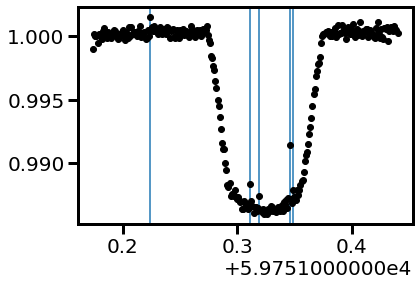

In [312]:
plt.errorbar(times, y/np.nanmedian(y), 
             yerr=yerr/np.nanmedian(y), 
             color='k', marker='o', linestyle='')
#plt.xlim(times[100]-0.5, times[200]-0.5)
plt.axvline(times[180])
plt.axvline(times[144])
plt.axvline(times[152])
plt.axvline(times[52])
plt.axvline(times[183]);

(100.0, 0.0)

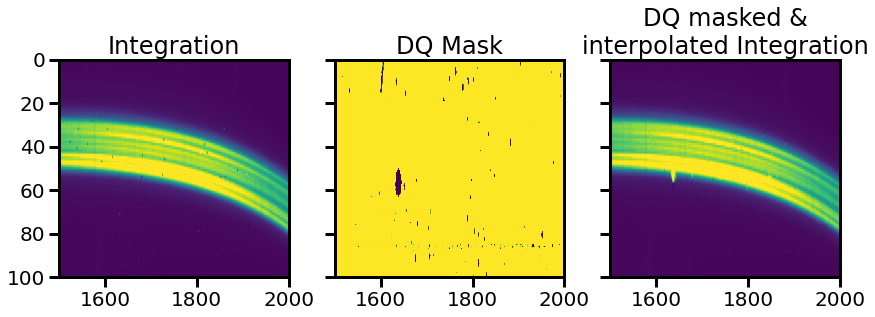

In [311]:
j = 52
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(14,4), sharex=True, sharey=True)
fig.set_facecolor('w')
ax1.imshow(frames[j], aspect='auto', vmin=0, vmax=200)
ax1.set_title('Integration')
ax2.imshow(dq[j]*frames[j], aspect='auto', vmin=0, vmax=1)
ax2.set_title('DQ Mask')
ax3.imshow(dq_masked[j], aspect='auto', vmin=0, vmax=200)
ax3.set_title('DQ masked &\ninterpolated Integration')
plt.xlim(1500,2000)
plt.ylim(100,0)
#plt.savefig('/Users/belugawhale/Desktop/dq_comp.png', dpi=300,
#            rasterize=True, bbox_inches='tight')

# Box Extraction

In [342]:
box_s, box_v = box_extract(subbed, subbed_var, order_mask)

(1500.0, 2200.0)

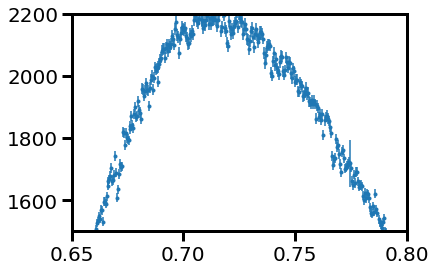

In [344]:
plt.errorbar(wave_soln[3].data['WAVELENGTH'], box_s[1][0], box_v[1][0], marker='.', linestyle='')
plt.xlim(0.65, 0.8)
plt.ylim(1500,2200)

# Optimal Extraction

In [345]:
medframe = np.nanmedian(subbed,axis=0)

In [346]:
opt_s, opt_e, opt_p = optimal_extraction_routine(subbed, 
                                                 np.sqrt(subbed_var),
                                                 spectrum=box_s,
                                                 spectrum_var=np.sqrt(box_v),
                                                 sky_bkg=backgrounds,
                                                 pos1=tab['order_1'],
                                                 pos2=tab['order_2'],
                                                 medframe=medframe,
                                                 per_quad=True,
                                                 sigma=80,
                                                 test=False, isplots=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [04:30<00:00,  1.04it/s]


In [347]:
opt_order1 = np.zeros((280, 2048))
optvar_order1 = np.zeros((280, 2048))
for i in range(280):
    offset = np.nanmedian([opt_s[2][i][-100:] - opt_s[0][i][100]])
    opt_order1[i] = np.append(opt_s[2][i]+offset, opt_s[0][i])
    
    offset = np.nanmedian([opt_e[2][i][-100:] - opt_e[0][i][100]])
    optvar_order1[i] = np.sqrt(np.append(opt_e[2][i]+offset, opt_e[0][i]))*2

In [348]:
opt_order2 = np.zeros((280, 2048))
optvar_order2 = np.zeros((280, 2048))
for i in range(280):
    opt_order2[i][1000:1900] = opt_s[1][i]
    optvar_order2[i][1000:1900] = np.sqrt(opt_e[1][i])*2

In [349]:
opt_order3 = np.zeros((280, 2048))
optvar_order3 = np.zeros((280, 2048))
for i in range(280):
    opt_order3[i][:1000] = opt_s[-1][i]
    optvar_order3[i][:1000] = np.sqrt(opt_e[-1][i])*2

(4000.0, 5500.0)

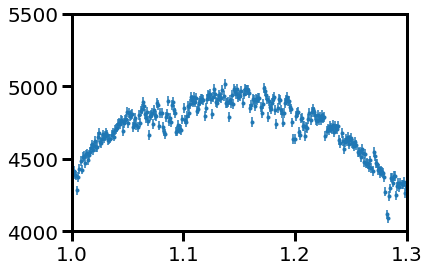

In [350]:
plt.errorbar(wave_soln[2].data['WAVELENGTH'], opt_order1[0], yerr=optvar_order1[0], marker='.',
             linestyle='')
plt.xlim(1,1.3)
plt.ylim(4000,5500)

In [351]:
opt_order1.shape

(280, 2048)

# Write file

In [353]:
badinds = np.sort(np.array([52, 103, 152, 159, 144, 180, 183]))
allinds = np.arange(0,len(times),1,dtype=int)
goodinds = np.delete(allinds, badinds)

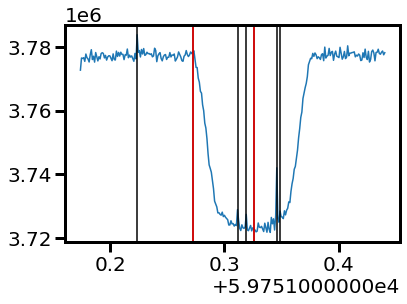

In [355]:
plt.plot(times, np.nansum(box_s[0], axis=1))
for b in badinds:
    plt.axvline(times[b], color='k')
plt.axvline(times[103], color='r')
plt.axvline(times[159], color='r')

In [362]:
data = h5py.File('ADF_extracted_stellar_spectra_final.h5', 'w')

data.create_dataset('time', data=times[goodinds])

#data.create_dataset('cr_rmvd_flux', data=cr_rmvd[goodinds])
#data.create_dataset('backgrounds', data=backgrounds[goodinds])
#data.create_dataset('clean_flux', data=subbed[goodinds])

#data.create_dataset('cr_rmvd_var', data=cr_rmvd_var[goodinds])
#data.create_dataset('backgrounds_var', data=backgrounds_var[goodinds])
#data.create_dataset('clean_variance', data=subbed_var[goodinds])

for i in range(1,4):
    data.create_dataset('box_extracted_flux_order_{}'.format(i), data=box_s[i-1][goodinds])
    data.create_dataset('box_extracted_var_order_{}'.format(i), data=box_v[i-1][goodinds])
    
    if i == 1:
        data.create_dataset('opt_flux_order_{}'.format(i), data=opt_order1[goodinds])
        data.create_dataset('opt_var_order_{}'.format(i), data=optvar_order1[goodinds])
    elif i == 2:
        data.create_dataset('opt_flux_order_{}'.format(i), data=opt_order2[goodinds])
        data.create_dataset('opt_var_order_{}'.format(i), data=optvar_order2[goodinds])
    else:
        data.create_dataset('opt_flux_order_{}'.format(i), data=opt_order3[goodinds])
        data.create_dataset('opt_var_order_{}'.format(i), data=optvar_order3[goodinds])
    

data.create_dataset('wavelength_order_1', data=wave_soln[2].data['WAVELENGTH'])
data.create_dataset('wavelength_order_2', data=wave_soln[3].data['WAVELENGTH'])
data.create_dataset('wavelength_order_3', data=wave_soln[4].data['WAVELENGTH'])

data.close()

In [363]:
np.save('ADF_med_frame_final.npy', np.nanmedian(subbed,axis=0))

In [356]:
data = h5py.File('ADF_extracted_stellar_spectra_method7.h5', 'w')

data.create_dataset('time', data=times[goodinds])

data.create_dataset('cr_rmvd_flux', data=cr_rmvd[goodinds])
data.create_dataset('backgrounds', data=backgrounds[goodinds])
data.create_dataset('clean_flux', data=subbed[goodinds])

data.create_dataset('cr_rmvd_var', data=cr_rmvd_var[goodinds])
data.create_dataset('backgrounds_var', data=backgrounds_var[goodinds])
data.create_dataset('clean_variance', data=subbed_var[goodinds])

for i in range(1,4):
    data.create_dataset('box_extracted_flux_order_{}'.format(i), data=box_s[i-1][goodinds])
    data.create_dataset('box_extracted_var_order_{}'.format(i), data=box_v[i-1][goodinds])
    """
    if i == 1:
        data.create_dataset('opt_flux_order_{}'.format(i), data=opt_order1[goodinds])
        data.create_dataset('opt_var_order_{}'.format(i), data=optvar_order1[goodinds])
    elif i == 2:
        data.create_dataset('opt_flux_order_{}'.format(i), data=opt_order2[goodinds])
        data.create_dataset('opt_var_order_{}'.format(i), data=optvar_order2[goodinds])
    else:
        data.create_dataset('opt_flux_order_{}'.format(i), data=opt_order3[goodinds])
        data.create_dataset('opt_var_order_{}'.format(i), data=optvar_order3[goodinds])
    """

data.create_dataset('wavelength_order_1', data=wave_soln[2].data['WAVELENGTH'])
data.create_dataset('wavelength_order_2', data=wave_soln[3].data['WAVELENGTH'])
data.create_dataset('wavelength_order_3', data=wave_soln[4].data['WAVELENGTH'])

data.close()

In [358]:
for i in range(1,4):
    np.save('/Users/belugawhale/Desktop/feinstein_wasp96_order{}_final.npy'.format(i),
            [wave_soln[i+1].data['WAVELENGTH'], box_s[i-1], box_v[i-1], times] )

In [360]:
all_traces.write('wasp96_traces_final.txt', format='csv', overwrite=True)

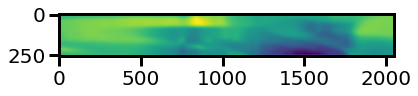

In [361]:
plt.imshow(med_bkg)

In [ ]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14,4))
ax1.plot(hdu[2].data['WAVELENGTH'], opt_order1[0])
ax2.plot(hdu[3].data['WAVELENGTH'], opt_order2[0])
ax3.plot(hdu[4].data['WAVELENGTH'][:1000], opt_s[2][0])

In [ ]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14,4))
ax1.plot(hdu[2].data['WAVELENGTH'], opt_order1[0]/optvar_order1[0])
ax2.plot(hdu[3].data['WAVELENGTH'], opt_order2[0]/optvar_order2[0])
ax3.plot(hdu[4].data['WAVELENGTH'][:1000], opt_s[2][0]/opt_e[2][0])

In [ ]:
data = h5py.File('ADF_wasp96_stellar_spectra.h5', 'w')

data.create_dataset('time', data=times-0.5)

#data.create_dataset('cr_rmvd_flux', data=cr_rmvd)
#data.create_dataset('backgrounds', data=backgrounds)
#data.create_dataset('clean_flux', data=subbed)

#data.create_dataset('cr_rmvd_var', data=cr_rmvd_var)
#data.create_dataset('backgrounds_var', data=backgrounds_var)
#data.create_dataset('clean_variance', data=subbed_var)


for i in range(1,4):
    data.create_dataset('box_flux_order_{}'.format(i), data=box_s[i-1])
    data.create_dataset('box_var_order_{}'.format(i), data=box_v[i-1])
    
    if i == 1:
        data.create_dataset('opt_flux_order_{}'.format(i), data=opt_order1)
        data.create_dataset('opt_var_order_{}'.format(i), data=optvar_order1)
    elif i == 2:
        data.create_dataset('opt_flux_order_{}'.format(i), data=opt_order2)
        data.create_dataset('opt_var_order_{}'.format(i), data=optvar_order2)
    else:
        data.create_dataset('opt_flux_order_{}'.format(i), data=opt_order3)
        data.create_dataset('opt_var_order_{}'.format(i), data=optvar_order3)

data.create_dataset('wavelength_order_1', data=wave_soln[2].data['WAVELENGTH'])
data.create_dataset('wavelength_order_2', data=wave_soln[3].data['WAVELENGTH'])
data.create_dataset('wavelength_order_3', data=wave_soln[4].data['WAVELENGTH'])

data.close()

In [ ]:
all_traces.add_column(Column(np.arange(0,2048,1), 'x'))

In [ ]:
all_traces.write('ADF_all_traces.csv', format='csv')

# Transit Fitting w/ Nestor's Reduction

In [ ]:
%load_ext autoreload
%autoreload 2

import juliet,a corner
from niriss.nestor_transit_fitting import fit_lightcurves

In [ ]:
priors1 = np.load('/Users/belugawhale/Downloads/priors_order1.pkl', allow_pickle=True)

In [ ]:
centers = np.zeros(len(priors1))
for i in range(len(priors1)):
    k = list(priors1.keys())[i].split('_')[-1]
    centers[i] = float(k)

In [ ]:
# fit the values from the white-light curve first then use the best-fit 
#     values from that as the fixed points in the fitting routine

In [ ]:
centers = np.logspace(np.log10(centers[0]), np.log10(centers[-1]), 50)
wave_offset = np.append(0.01,np.diff(centers)/2)

# Name of the parameters to be fit:
#params = np.array(list(priors1['wbin_order1_0.85006'].keys())[:-2])
#params = np.delete(params, -3)
#params = np.append(params, ['r1_p1', 'r2_p2'])


# Name of the parameters to be fit:
params = ['P_p1','t0_p1','p_p1','b_p1', 'q1_SOSS',
          'q2_SOSS','ecc_p1','omega_p1',
          'rho', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

# Distributions:
dists = ['fixed',
         'fixed',
         'uniform','normal', 
         'uniform',
         'uniform',
         'fixed','fixed',
         'fixed', 
         'fixed', 'normal', 'loguniform'] 

# Hyperparameters
hyperps = [3.4252602, 
           [2459751.824667617-2400000,0.1], 
           [0.,0.2], 
           [0.4,0.2], 
           #[0., 0.2],
           [0., 1.0],#[0.4, 0.1, 0.0, 1.0], 
           [0., 1.0],#[0.4, 0.1, 0.0, 1.0], 
           0.0, 90.,
           [100., 10000.], 
           1.0, 
           [0.0,0.1], 
           [10.0, 1000.]]


data_dictionary = {}
priors = {}

for i in range(len(centers)):
    key = 'wave_{}'.format(np.round(centers[i],5))
    #os.mkdir(key)
    

    q = ((wave_soln[2].data['WAVELENGTH'] >= centers[i]-wave_offset[i]) &
         (wave_soln[2].data['WAVELENGTH'] <= centers[i]+wave_offset[i]) )
    y = np.nansum(box_s[0][goodinds][:,q], axis=1)
    yerr = np.sqrt(np.nansum(box_v[0][goodinds][:,q], axis=1))
    data_dictionary[key] = {'times':times[goodinds]+2400000.5,
                            'flux':y/np.nanmedian(y),
                            'error':yerr/np.nanmedian(y)*4}
    
    data = np.array([times[goodinds], y/np.nanmedian(y), yerr/np.nanmedian(y), 
                     np.full(len(times[goodinds]), 'SOSS', dtype='U10')]).T
    with open(os.path.join(key, 'lc.dat'), 'w') as f:
        for i in range(len(data)):
            f.write('{0}\n'.format(' '.join(str(e) for e in data[i])))
    with open(os.path.join(key, 'priors.dat'), 'w') as f:
        f.write(' ')

    temp = {}
    
    for param, dist, hyperp in zip(params, dists, hyperps):
        temp[param] = {}
        temp[param]['distribution'] = dist
        temp[param]['hyperparameters'] = hyperp
    priors[key] = priors1['wbin_order1_0.85006']
    #priors[key].pop('a_p1')
    #priors[key].pop('b_p1')
    #priors[key].pop('rho')
    #priors[key].pop('p_p1')

In [ ]:
results = fit_lightcurves(data_dictionary,  priors, sampler='dynesty')

### Corner plots